<a href="https://colab.research.google.com/github/saraspreitzhofer/knapsack_pso_hybrid/blob/main/ParticleSwarmOptimizationKnapsack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization

In [ ]:
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from itertools import product

In [ ]:
# constants
NBR_ITEMS = 250       # number of randomly generated items
MAX_PROFIT = 100      # maximum profit of each item
MAX_SPACE = 50        # maximum capacity of each item
DIMENSION = 10        # dimensions of the knapsack
NBR_EXPERIMENTS = 100   # number of experiments for statistical evaluation
NBR_KNAPSACKS = 5     # number of knapsacks for the multiple multidimensional knapsack problem

BOUNDS = []
for i in range (NBR_ITEMS):
  BOUNDS.append((0, 1))

In [ ]:
# To assure reproducibility, the RNG seed is set prior to the items dict initialization
random.seed(64)

In [ ]:
# function to create random 1-dimensional items
def create_items():
  # Create a dictionary of NBR_ITEMS random items to map the values and weights.
  # Create the item dictionary: item name is an integer, and value is a (value, weight) 2-tuple.
  items = {}
  # Create random items and store them in the items' dictionary.
  for i in range(NBR_ITEMS):
      items[i] = (random.randint(1, MAX_PROFIT), random.randint(1, 15))
  return items

In [ ]:
# function to create random 2-dimensional items
def create_items_2d():
  # Create a dictionary of NBR_ITEMS random items to map the values, weights and volumes.
  # Create the item dictionary: item name is an integer, and value is a (value, weight, volume) 3-tuple.
  items2d = {}
  # Create random items and store them in the items' dictionary.
  for i in range(NBR_ITEMS):
      items2d[i] = (random.randint(1, MAX_PROFIT), random.randint(1, 15), random.randint(1, 10))
  return items2d

In [ ]:
# function to create random n-dimensional items
def create_items_nd():
  # Create a dictionary of NBR_ITEMS random items to map the values, ....
  # Create the item dictionary: item name is an integer, and value is a (value, ...) n-tuple.
  itemsnd = {}
  # Create random items and store them in the items' dictionary.
  for i in range(NBR_ITEMS):
    values = []
    values.append(random.randint(1, MAX_PROFIT))  # value (= dimension 0)
    for j in range(1, DIMENSION+1):
      values.append(random.randint(1, 15)) # dimensions 1 to n
    itemsnd[i] = values
  return itemsnd

In [ ]:
# function to calculate the runtime of any function specified as parameter
def calcTime(function, *args):
  start = time.perf_counter()         # get current time    
  function(*args)
  end = time.perf_counter()
  elapsed = (end - start) * 100       # compute time value in milliseconds
  elapsed = round(elapsed, 5)         
  # print("Elapsed time until solved: " + str(elapsed) + " milliseconds")
  return elapsed

# Fitness functions

In [ ]:
def fitness_1d(individual, data):  # individual = candidate solution (binary vector)
  values, weights = 0, 0
  for (selected, item) in zip(individual, data):  # selected = 0 or 1
    if selected and (weights + item[1]) <= MAX_SPACE:
      values += item[0]
      weights += item[1]
  if weights > MAX_SPACE:
    values = 0
  return values               # maxprofit 

In [ ]:
# define a fitness function
def fitness_nd(individual, data):    # individual = array of 0s & 1s
    used_space = []
    error = 0
    for i in range(DIMENSION+1):
      used_space.append(0)
    for (selected, item) in zip(individual, data):  # selected = 0 or 1
        if selected:
            for i in range(1, DIMENSION+1):
              if (used_space[i]+item[i]) > MAX_SPACE:   # if one dimension is higher that the capacity -> error = 1
                error = 1                  
              if error < 1:
                used_space[i] += item[i]
            if error < 1:
              used_space[0] += item[0]                # profit
            else:
               error = 0

    return used_space[0]  # maxprofit

In [ ]:
# define a fitness function
def fitness(individual, data):    # individual = array of k arrays of 0s & 1s
    used_space = []   # used space for each dimension for each knapsack
    error = 0
    maxprofit = 0

    for k in range(NBR_KNAPSACKS):
      knapsack_used_space = []
      for i in range(DIMENSION+1):
        knapsack_used_space.append(0)
      used_space.append(knapsack_used_space)

    for k in range(NBR_KNAPSACKS):
      for (selected, item) in zip(individual[k], data):  # selected = 0 or 1
          if selected:
              for i in range(1, DIMENSION+1):
                if (used_space[k][i]+item[i]) > MAX_SPACE:    # if one dimension is higher that the capacity -> error = 1
                  error = 1                  
                if error < 1:
                  used_space[k][i] += item[i]
              if error < 1:
                used_space[k][0] += item[0]                # profit
              else:
                error = 0

    # calculate maxprofit as sum of the profits of all knapsacks
    for k in range (NBR_KNAPSACKS):
      maxprofit = maxprofit + used_space[k][0]

    return maxprofit

# PSO

In [ ]:
class Particle:
    def __init__(self, bounds, data):
        self.position = np.random.randint(2, size=NBR_ITEMS)
        self.velocity = np.zeros(NBR_ITEMS)
        self.best_position = np.zeros(NBR_ITEMS)
        self.bounds = bounds
        self.data = data
        self.fitness = None
        self.best_fitness = float('-inf')
        
    def evaluate(self, fitness_func):
        self.fitness = fitness_func(self.position, self.data)
        if self.fitness > self.best_fitness:
            self.best_position = self.position
            self.best_fitness = self.fitness
    
    def update_velocity(self, global_best_position, w, c1, c2):
        # r1, r2: random values between 0 and 1
        r1 = np.random.rand(NBR_ITEMS)
        r2 = np.random.rand(NBR_ITEMS)
        self.velocity = w*self.velocity + c1*r1*(self.best_position - self.position) + c2*r2*(global_best_position - self.position)

    def update_position(self):
        self.position = np.clip(np.round(self.position + self.velocity), 0, 1)

    # new hybrid
    def set_position(self, new_position):
        self.position = new_position

In [ ]:
class ParticleSwarm:
    def __init__(self, bounds, data, fitness_func, num_particles=30, max_iter=100, w=0.5, c1=0.5, c2=0.5):
        # bounds = list of (0, 1) tuples, representing lower and upper bounds
        self.bounds = bounds
        self.data = data
        self.fitness_func = fitness_func
        # num_particles: number of particles in the swarm
        self.num_particles = num_particles
        # max_iter: maximum number of iterations to run the algorithm for
        self.max_iter = max_iter
        # w: inertia weight, controls the particle's movement in the search space
        self.w = w
        # phi_p: cognitive parameter, controls the particle's movement in the search space
        self.c1 = c1
        # phi_g: social parameter, controls the particle's movement in the search space
        self.c2 = c2
        self.particles = [Particle(bounds, data) for i in range(num_particles)]
        self.global_best_position = None
        self.global_best_fitness = float('-inf')
        self.fitness_history = []
        
    def solve(self):
        for i in range(self.max_iter):
            for particle in self.particles:
                particle.evaluate(self.fitness_func)
                if particle.fitness > self.global_best_fitness:
                    self.global_best_position = particle.position
                    self.global_best_fitness = particle.fitness
            self.fitness_history.append(self.global_best_fitness)
            for particle in self.particles:
                particle.update_velocity(self.global_best_position, self.w, self.c1, self.c2)
                particle.update_position()
                
    def get_solution(self):
        return self.global_best_position
    
    def get_fitness_history(self):
        return self.fitness_history

    def get_profit(self):
        return self.global_best_fitness

    # new hybrid
    def get_solution_population(self, individuals):
        solution_population = []

        for particle in individuals:
            particle.fitness = self.fitness_func(particle.genes, self.data)
            if particle.fitness > self.global_best_fitness:
                self.global_best_position = particle.genes
                self.global_best_fitness = particle.fitness
        
        for particle in individuals:
            new_particle = Particle(BOUNDS, self.data)
            new_particle.set_position(particle.genes)
            new_particle.update_velocity(np.array(self.global_best_position), self.w, self.c1, self.c2)
            new_particle.update_position()
            solution_population.append(new_particle.position)
        
        return solution_population

# PSO, 1-dimensional 0-1 Knapsack
https://medium.com/analytics-vidhya/implementing-particle-swarm-optimization-pso-algorithm-in-python-9efc2eb179a6

In [ ]:
def grid_search_knapsack(num_particles_range, w_range, c1_range, c2_range, max_iter = 100):
    best_fitness = 0
    best_position = None
    best_num_particles = 0
    best_w = 0
    best_c1 = 0
    best_c2 = 0
    test_data = create_items().values()
    for num_particles, w, c1, c2 in product(num_particles_range, w_range, c1_range, c2_range):
        pso = ParticleSwarm(BOUNDS, test_data, fitness_1d, num_particles, max_iter, w, c1, c2)
        pso.solve()
        position = pso.get_solution()
        fitness = pso.get_profit()
        if fitness > best_fitness:
            best_fitness = fitness
            best_position = position
            best_num_particles = num_particles
            best_w = w
            best_c1 = c1
            best_c2 = c2
    return best_position, best_fitness, best_num_particles, best_w, best_c1, best_c2

In [ ]:
# grid search for hyperparameter tuning
'''fitness = 0
num_particles = 0
w = 0
c1 = 0
c2 = 0
for i in range (NBR_EXPERIMENTS):
  print(i+1)
  test_data = create_items().values()
  best_position, best_fitness, best_num_particles, best_w, best_c1, best_c2 = grid_search_knapsack(num_particles_range = (20, 40), w_range = (0, 1), c1_range = (0, 1), c2_range = (0, 1))
  fitness = fitness + best_fitness
  num_particles = num_particles + best_num_particles
  w = w + best_w
  c1 = c1 + best_c1
  c2 = c2 + best_c2

fitness = fitness / NBR_EXPERIMENTS
num_particles = num_particles / NBR_EXPERIMENTS
w = w / NBR_EXPERIMENTS
c1 = c1 / NBR_EXPERIMENTS
c2 = c2 / NBR_EXPERIMENTS

print("Grid Search for PSO:")
print("num_particles_range = (20, 40)")
print("w_range = (0, 1)")
print("c1_range = (0, 1)")
print("c2_range = (0, 1)")
print("fitness", fitness)
print("num_particles", num_particles)
print("w", w)
print("c1", c1)
print("c2", c2)'''

'fitness = 0\nnum_particles = 0\nw = 0\nc1 = 0\nc2 = 0\nfor i in range (NBR_EXPERIMENTS):\n  print(i+1)\n  test_data = create_items().values()\n  best_position, best_fitness, best_num_particles, best_w, best_c1, best_c2 = grid_search_knapsack(num_particles_range = (20, 40), w_range = (0, 1), c1_range = (0, 1), c2_range = (0, 1))\n  fitness = fitness + best_fitness\n  num_particles = num_particles + best_num_particles\n  w = w + best_w\n  c1 = c1 + best_c1\n  c2 = c2 + best_c2\n\nfitness = fitness / NBR_EXPERIMENTS\nnum_particles = num_particles / NBR_EXPERIMENTS\nw = w / NBR_EXPERIMENTS\nc1 = c1 / NBR_EXPERIMENTS\nc2 = c2 / NBR_EXPERIMENTS\n\nprint("Grid Search for PSO:")\nprint("num_particles_range = (20, 40)")\nprint("w_range = (0, 1)")\nprint("c1_range = (0, 1)")\nprint("c2_range = (0, 1)")\nprint("fitness", fitness)\nprint("num_particles", num_particles)\nprint("w", w)\nprint("c1", c1)\nprint("c2", c2)'

In [ ]:
# statistical evaluation to compare two different parameter combinations for the PSO

avgtimePSO1 = 0
avgtimePSO2 = 0
profitPSO1 = 0
profitPSO2 = 0

for j in range (NBR_EXPERIMENTS):

  fitness_historyPSO1 = []
  fitness_historyPSO2 = []

  print(j+1)
  DATA = create_items().values()

  pso1 = ParticleSwarm(BOUNDS, DATA, fitness_1d, num_particles=30, max_iter=20, w=0.22, c1=0.78, c2=0.98)
  pso2 = ParticleSwarm(BOUNDS, DATA, fitness_1d, num_particles=30, max_iter=20, w=0.22, c1=0.78, c2=0.98)

  # get time
  elapsed1 = calcTime(pso1.solve)
  elapsed2 = calcTime(pso2.solve)
  avgtimePSO1 = avgtimePSO1 + elapsed1
  avgtimePSO2 = avgtimePSO2 + elapsed2

  # get maxprofit
  profitPSO1 = profitPSO1 + pso1.get_profit()
  profitPSO2 = profitPSO2 + pso2.get_profit()

  # get fitness_history
  for k in range (len(pso1.get_fitness_history())):
    fitness_historyPSO1.append(0)
    fitness_historyPSO2.append(0)
  for k in range (len(pso1.get_fitness_history())):
    fitness_historyPSO1[k] = fitness_historyPSO1[k] + pso1.get_fitness_history()[k]
    fitness_historyPSO2[k] = fitness_historyPSO2[k] + pso2.get_fitness_history()[k]
  
avgtimePSO1 = round(avgtimePSO1 / NBR_EXPERIMENTS, 5)
avgtimePSO2 = round(avgtimePSO2 / NBR_EXPERIMENTS, 5)

profitPSO1 = round(profitPSO1 / NBR_EXPERIMENTS, 5)
profitPSO2 = round(profitPSO2 / NBR_EXPERIMENTS, 5)

for k in range(len(fitness_historyPSO1)):
  fitness_historyPSO1[k] = round(fitness_historyPSO1[k] / NBR_EXPERIMENTS, 5)
  fitness_historyPSO2[k] = round(fitness_historyPSO2[k] / NBR_EXPERIMENTS, 5)

print("Statistical evaluation of the PSO for the 1-dimensional 0-1 knapsack")
print("\tmillisec\tmaxprofit")
print("PSO1\t", avgtimePSO1, "\t", profitPSO1)
print("PSO2\t", avgtimePSO2, "\t", profitPSO2)

1
2
3
4
5
6
7
8
9
10
Statistical evaluation of the PSO for the 1-dimensional 0-1 knapsack
	millisec	maxprofit
PSO1	 4.87897 	 840.0
PSO2	 4.86956 	 792.9


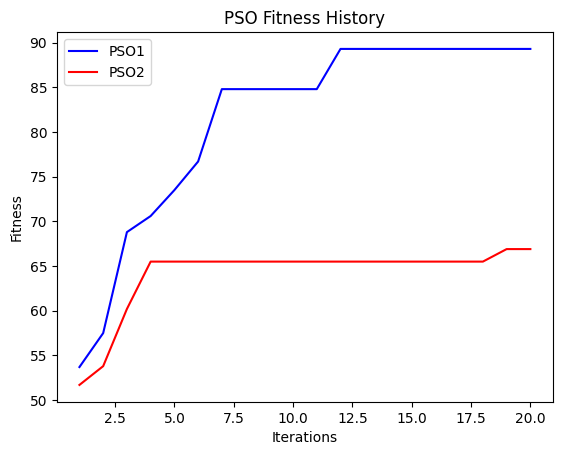

In [ ]:
iterations = []
for i in range(len(fitness_historyPSO1)):
  iterations.append(i+1)

plt.title("PSO Fitness History")
plt.xlabel("Iterations")
plt.ylabel("Fitness")
plt.plot(iterations, fitness_historyPSO1, color = "blue", label = "PSO1")
plt.plot(iterations, fitness_historyPSO2, color = "red", label = "PSO2")
plt.legend()
plt.show()

# PSO, n-dimensional 0-1 Knapsack

In [ ]:
# statistical evaluation to compare two different parameter combinations for the PSO

avgtimePSO1 = 0
avgtimePSO2 = 0
profitPSO1 = 0
profitPSO2 = 0

for j in range (NBR_EXPERIMENTS):

  fitness_historyPSO1 = []
  fitness_historyPSO2 = []

  print(j+1)
  DATA = create_items_nd().values()

  pso1 = ParticleSwarm(BOUNDS, DATA, fitness_nd, num_particles=30, max_iter=30, w=0.22, c1=0.78, c2=0.98)
  pso2 = ParticleSwarm(BOUNDS, DATA, fitness_nd, num_particles=30, max_iter=30, w=0.22, c1=0.78, c2=0.98)

  # get time
  elapsed1 = calcTime(pso1.solve)
  elapsed2 = calcTime(pso2.solve)
  avgtimePSO1 = avgtimePSO1 + elapsed1
  avgtimePSO2 = avgtimePSO2 + elapsed2

  # get maxprofit
  profitPSO1 = profitPSO1 + pso1.get_profit()
  profitPSO2 = profitPSO2 + pso2.get_profit()

  # get fitness_history
  for k in range (len(pso1.get_fitness_history())):
    fitness_historyPSO1.append(0)
    fitness_historyPSO2.append(0)
  for k in range (len(pso1.get_fitness_history())):
    fitness_historyPSO1[k] = fitness_historyPSO1[k] + pso1.get_fitness_history()[k]
    fitness_historyPSO2[k] = fitness_historyPSO2[k] + pso2.get_fitness_history()[k]
  
avgtimePSO1 = round(avgtimePSO1 / NBR_EXPERIMENTS, 5)
avgtimePSO2 = round(avgtimePSO2 / NBR_EXPERIMENTS, 5)

profitPSO1 = round(profitPSO1 / NBR_EXPERIMENTS, 5)
profitPSO2 = round(profitPSO2 / NBR_EXPERIMENTS, 5)

for k in range(len(fitness_historyPSO1)):
  fitness_historyPSO1[k] = round(fitness_historyPSO1[k] / NBR_EXPERIMENTS, 5)
  fitness_historyPSO2[k] = round(fitness_historyPSO2[k] / NBR_EXPERIMENTS, 5)

print("Statistical evaluation of the PSO for the n-dimensional 0-1 knapsack")
print("\tmillisec\tmaxprofit")
print("PSO1\t", avgtimePSO1, "\t", profitPSO1)
print("PSO2\t", avgtimePSO2, "\t", profitPSO2)

1
2
3
4
5
6
7
8
9
10
Statistical evaluation of the PSO for the n-dimensional 0-1 knapsack
	millisec	maxprofit
PSO1	 24.86697 	 366.2
PSO2	 25.9937 	 365.4


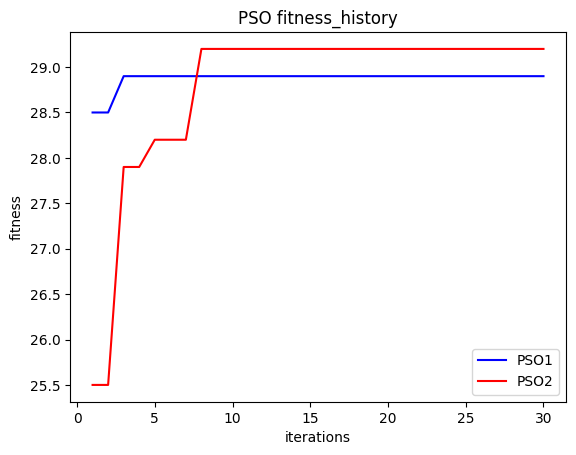

In [ ]:
iterations = []
for i in range(len(fitness_historyPSO1)):
  iterations.append(i+1)

plt.title("PSO fitness_history")
plt.xlabel("iterations")
plt.ylabel("fitness")
plt.plot(iterations, fitness_historyPSO1, color = "blue", label = "PSO1")
plt.plot(iterations, fitness_historyPSO2, color = "red", label = "PSO2")
plt.legend()
plt.show()

# PSO multiple

In [ ]:
class ParticleMultiple:
    def __init__(self, bounds, data):
        self.position = []
        self.velocity = []
        self.best_position = []

        for i in range (NBR_KNAPSACKS):                               # difference to Particle
            position_knapsack = np.random.randint(2, size=NBR_ITEMS)
            self.position.append(list(position_knapsack))

            velocity_knapsack = np.zeros(NBR_ITEMS)
            self.velocity.append(list(velocity_knapsack))
            
            best_position_knapsack = np.zeros(NBR_ITEMS)
            self.best_position.append(list(best_position_knapsack))
        
        self.bounds = bounds
        self.data = data
        self.fitness = None
        self.best_fitness = float('-inf')
        
    def evaluate(self, fitness_func):
        self.fitness = fitness_func(self.position, self.data)
        if self.fitness > self.best_fitness:
            self.best_position = self.position
            self.best_fitness = self.fitness
    
    def update_velocity(self, global_best_position, w, c1, c2):         # difference to Particle
        # r1, r2: random values between 0 and 1
        r1 = np.empty((NBR_KNAPSACKS, NBR_ITEMS))
        r2 = np.empty((NBR_KNAPSACKS, NBR_ITEMS))
        w_times_velocity = np.empty((NBR_KNAPSACKS, NBR_ITEMS))
        for i in range (NBR_KNAPSACKS):
            r1[i] = np.random.rand(NBR_ITEMS)
            r2[i] = np.random.rand(NBR_ITEMS)
            for j in range(NBR_ITEMS):
                w_times_velocity[i][j] = w * self.velocity[i][j]

        self_position_difference = np.empty((NBR_KNAPSACKS, NBR_ITEMS))
        global_position_difference = np.empty((NBR_KNAPSACKS, NBR_ITEMS))
        for i in range (NBR_KNAPSACKS): 
            self_position_difference[i] = np.array(self.best_position[i]) - np.array(self.position[i])
            global_position_difference[i] = np.array(global_best_position[i]) - np.array(self.position[i])
        
        self.velocity = w_times_velocity + c1*r1*self_position_difference + c2*r2*global_position_difference
        
    def update_position(self):                                          # difference to Particle
        tmp = self.position
        self.position = np.empty((NBR_KNAPSACKS, NBR_ITEMS))
        for i in range (NBR_KNAPSACKS):
            self.position[i] = np.zeros(NBR_ITEMS)
        for i in range (NBR_KNAPSACKS):
            self.position[i] = np.clip(np.round(tmp[i] + self.velocity[i]), 0, 1)

    # new hybrid
    def set_position(self, new_position):
        self.position = new_position            

In [ ]:
class ParticleSwarmMultiple:
    def __init__(self, bounds, data, fitness_func, num_particles=30, max_iter=100, w=0.5, c1=0.5, c2=0.5):
        # bounds = list of (0, 1) tuples, representing lower and upper bounds
        self.bounds = bounds
        self.data = data
        self.fitness_func = fitness_func
        # num_particles: number of particles in the swarm
        self.num_particles = num_particles
        # max_iter: maximum number of iterations to run the algorithm for
        self.max_iter = max_iter
        # w: inertia weight, controls the particle's movement in the search space
        self.w = w
        # phi_p: cognitive parameter, controls the particle's movement in the search space
        self.c1 = c1
        # phi_g: social parameter, controls the particle's movement in the search space
        self.c2 = c2
        self.particles = [ParticleMultiple(bounds, data) for i in range(num_particles)]   # difference to ParticleSwarm
        self.global_best_position = None
        self.global_best_fitness = float('-inf')
        self.fitness_history = []
        
    def solve(self):
        for i in range(self.max_iter):
            for particle in self.particles:
                particle.evaluate(self.fitness_func)
                if particle.fitness > self.global_best_fitness:
                    self.global_best_position = particle.position
                    self.global_best_fitness = particle.fitness
            self.fitness_history.append(self.global_best_fitness)
            for particle in self.particles:
                particle.update_velocity(self.global_best_position, self.w, self.c1, self.c2)
                particle.update_position()
                
    def get_solution(self):
        return self.global_best_position
    
    def get_fitness_history(self):
        return self.fitness_history

    def get_profit(self):
        return self.global_best_fitness

    # new hybrid
    def get_solution_population(self, individuals):
        solution_population = []

        for particle in individuals:
            particle.fitness = self.fitness_func(particle.genes, self.data)
            if particle.fitness > self.global_best_fitness:
                self.global_best_position = particle.genes
                self.global_best_fitness = particle.fitness
        
        for particle in individuals:
            new_particle = Particle(BOUNDS, self.data)
            new_particle.set_position(particle.genes)
            new_particle.update_velocity(np.array(self.global_best_position), self.w, self.c1, self.c2)
            new_particle.update_position()
            solution_population.append(new_particle.position)
        
        return solution_population        

# PSO, multiple n-dimensional 0-1 Knapsack

In [ ]:
# statistical evaluation to compare two different parameter combinations for the PSO

avgtimePSO1 = 0
avgtimePSO2 = 0
profitPSO1 = 0
profitPSO2 = 0

for j in range (NBR_EXPERIMENTS):

  fitness_historyPSO1 = []
  fitness_historyPSO2 = []

  print(j+1)
  DATA = create_items_nd().values()

  pso1 = ParticleSwarmMultiple(BOUNDS, DATA, fitness, num_particles=30, max_iter=100, w=0.22, c1=0.78, c2=0.98)
  pso2 = ParticleSwarmMultiple(BOUNDS, DATA, fitness, num_particles=30, max_iter=100, w=0.22, c1=0.78, c2=0.98)

  # get time
  elapsed1 = calcTime(pso1.solve)
  elapsed2 = calcTime(pso2.solve)
  avgtimePSO1 = avgtimePSO1 + elapsed1
  avgtimePSO2 = avgtimePSO2 + elapsed2

  # get maxprofit
  profitPSO1 = profitPSO1 + pso1.get_profit()
  profitPSO2 = profitPSO2 + pso2.get_profit()

  # get fitness_history
  for k in range (len(pso1.get_fitness_history())):
    fitness_historyPSO1.append(0)
    fitness_historyPSO2.append(0)
  for k in range (len(pso1.get_fitness_history())):
    fitness_historyPSO1[k] = fitness_historyPSO1[k] + pso1.get_fitness_history()[k]
    fitness_historyPSO2[k] = fitness_historyPSO2[k] + pso2.get_fitness_history()[k]
  
avgtimePSO1 = round(avgtimePSO1 / NBR_EXPERIMENTS, 5)
avgtimePSO2 = round(avgtimePSO2 / NBR_EXPERIMENTS, 5)

profitPSO1 = round(profitPSO1 / NBR_EXPERIMENTS, 5)
profitPSO2 = round(profitPSO2 / NBR_EXPERIMENTS, 5)

for k in range(len(fitness_historyPSO1)):
  fitness_historyPSO1[k] = round(fitness_historyPSO1[k] / NBR_EXPERIMENTS, 5)
  fitness_historyPSO2[k] = round(fitness_historyPSO2[k] / NBR_EXPERIMENTS, 5)

print("Statistical evaluation of the PSO for the multiple n-dimensional 0-1 knapsack")
print("\tmillisec\tmaxprofit")
print("PSO1\t", avgtimePSO1, "\t", profitPSO1)
print("PSO2\t", avgtimePSO2, "\t", profitPSO2)

1
2
3
4
5
6
7
8
9
10
Statistical evaluation of the PSO for the multiple n-dimensional 0-1 knapsack
	millisec	maxprofit
PSO1	 765.80777 	 1684.9
PSO2	 756.86865 	 1717.7


# Hybrid

In [ ]:
W = 0.22
C1 = 0.78
C2 = 0.98

# constants for the genetic algorithm
NGEN = 75             # number of generations
MU = 150              # population size
CXPB = 0.8            # crossover probability
MUTPB = 0.2           # mutation probability

In [ ]:
import copy
from operator import attrgetter
from six.moves import range

class HybridAlgorithm(object):

    def __init__(self,
                 seed_data,
                 max_capacity,    # for the improved create_individual function
                 number_of_dimensions=1,    # for the improved create_individual function, n-dimensional
                 population_size=MU,
                 generations=NGEN,
                 crossover_probability=CXPB,
                 mutation_probability=MUTPB,
                 elitism=True,
                 maximise_fitness=True):
        """
        :param seed_data: input data to the Genetic Algorithm
        :type seed_data: list of objects
        :param int population_size: size of population
        :param int generations: number of generations to evolve
        :param float crossover_probability: probability of crossover operation
        :param float mutation_probability: probability of mutation operation

        """

        self.seed_data = seed_data
        self.max_capacity = max_capacity    # for the improved create_individual function
        self.number_of_dimensions = number_of_dimensions    # for the improved create_individual function, n-dimensional
        self.population_size = population_size
        self.generations = generations
        self.crossover_probability = crossover_probability
        self.mutation_probability = mutation_probability
        self.elitism = elitism
        self.maximise_fitness = maximise_fitness

        self.current_generation = []

        def create_individual(seed_data):
            """Create a candidate solution representation.

            e.g. for a bit array representation:

            >>> return [random.randint(0, 1) for _ in range(len(data))]

            :param seed_data: input data to the Genetic Algorithm
            :type seed_data: list of objects
            :returns: candidate solution representation as a list

            """

            feasible = True
            individual_list = []
            random.shuffle(seed_data)

            # n-dimensional
            capacity = []
            for i in range(number_of_dimensions):
              capacity.append(0)

            for item in seed_data:
              r = random.randint(0, 1)
              if(r):
                for i in range(number_of_dimensions):
                  capacity[i] = capacity[i] + item[i+1]
                  if capacity[i] > self.max_capacity:
                    individual_list.append(0)
                    feasible = False
                    break
              if not feasible:
                break
              individual_list.append(r)

            for i in range(len(seed_data)-len(individual_list)):
              individual_list.append(0)

            return individual_list

        def crossover(parent_1, parent_2):
            """Crossover (mate) two parents to produce two children.

            :param parent_1: candidate solution representation (list)
            :param parent_2: candidate solution representation (list)
            :returns: tuple containing two children

            """
            index = random.randrange(1, len(parent_1))
            child_1 = parent_1[:index] + parent_2[index:]
            child_2 = parent_2[:index] + parent_1[index:]
            return child_1, child_2

        # new for hybrid algorithm
        def mutate(individual):
            """Reverse the bit of a random index in an individual."""
            mutate_index = random.randrange(len(individual))
            # individual[mutate_index] = (0, 1)[individual[mutate_index] == 0]

            # r1, r2: random values between 0 and 1
            r1 = np.random.rand()
            r2 = np.random.rand()
            # b is upper bound vector of individuals
            # elite is optimal individual of former-generation
            b = []
            for i in range (NBR_ITEMS):
              b.append(1)
            elite = copy.deepcopy(self.current_generation[0].genes)
            individual[mutate_index] = np.clip(np.round(W*individual[mutate_index] + C1*r1*(b[mutate_index]-individual[mutate_index]) + C2*r2*(elite[mutate_index]-individual[mutate_index])), 0, 1)

        def random_selection(population):
            """Select and return a random member of the population."""
            return random.choice(population)

        def tournament_selection(population):
            """Select a random number of individuals from the population and
            return the fittest member of them all.
            """
            if self.tournament_size == 0:
                self.tournament_size = 2
            members = random.sample(population, self.tournament_size)
            members.sort(
                key=attrgetter('fitness'), reverse=self.maximise_fitness)
            return members[0]

        self.fitness_function = None
        self.tournament_selection = tournament_selection
        self.tournament_size = self.population_size // 10
        self.random_selection = random_selection
        self.create_individual = create_individual
        self.crossover_function = crossover
        self.mutate_function = mutate
        self.selection_function = self.tournament_selection

    def create_initial_population(self):
        """Create members of the first population randomly.
        """
        initial_population = []
        solution_population = []  # new hybrid
        
        for _ in range(self.population_size):
            genes = self.create_individual(self.seed_data)
            individual = Chromosome(genes)
            initial_population.append(individual)
            
        # new hybrid
        pso = ParticleSwarm(BOUNDS, self.seed_data, self.fitness_function, num_particles=30, max_iter=1, w=W, c1=C1, c2=C2)
        current_generation = pso.get_solution_population(initial_population)
        for genes in current_generation:
            individual = Chromosome(list(genes))
            solution_population.append(individual)

        self.current_generation = solution_population

    def calculate_population_fitness(self):
        """Calculate the fitness of every member of the given population using
        the supplied fitness_function.
        """
        for individual in self.current_generation:
            individual.fitness = self.fitness_function(
                individual.genes, self.seed_data)

    def rank_population(self):
        """Sort the population by fitness according to the order defined by
        maximise_fitness.
        """
        self.current_generation.sort(
            key=attrgetter('fitness'), reverse=self.maximise_fitness)

    def create_new_population(self):
        """Create a new population using the genetic operators (selection,
        crossover, and mutation) supplied.
        """
        new_population = []
        elite = copy.deepcopy(self.current_generation[0])
        selection = self.selection_function

        while len(new_population) < self.population_size:
            parent_1 = copy.deepcopy(selection(self.current_generation))
            parent_2 = copy.deepcopy(selection(self.current_generation))

            child_1, child_2 = parent_1, parent_2
            child_1.fitness, child_2.fitness = 0, 0

            can_crossover = random.random() < self.crossover_probability
            can_mutate = random.random() < self.mutation_probability

            if can_crossover:
                child_1.genes, child_2.genes = self.crossover_function(
                    parent_1.genes, parent_2.genes)

            if can_mutate:
                self.mutate_function(child_1.genes)
                self.mutate_function(child_2.genes)

            new_population.append(child_1)
            if len(new_population) < self.population_size:
                new_population.append(child_2)

        if self.elitism:
            new_population[0] = elite

        self.current_generation = new_population

    def create_first_generation(self):
        """Create the first population, calculate the population's fitness and
        rank the population by fitness according to the order specified.
        """
        self.create_initial_population()
        self.calculate_population_fitness()
        self.rank_population()

    def create_next_generation(self):
        """Create subsequent populations, calculate the population fitness and
        rank the population by fitness in the order specified.
        """
        self.create_new_population()
        self.calculate_population_fitness()
        self.rank_population()

    def run(self):
        """Run (solve) the Genetic Algorithm."""
        self.create_first_generation()
        for _ in range(1, self.generations):
            self.create_next_generation()

    def best_individual(self):
        """Return the individual with the best fitness in the current
        generation.
        """
        best = self.current_generation[0]
        return (best.fitness, best.genes)

    def last_generation(self):
        """Return members of the last generation as a generator function."""
        return ((member.fitness, member.genes) for member
                in self.current_generation)

In [ ]:
class Chromosome(object):
    """ Chromosome class that encapsulates an individual's fitness and solution
    representation.
    """
    def __init__(self, genes):
        """Initialise the Chromosome."""
        self.genes = genes
        self.fitness = 0

    def __repr__(self):
        """Return initialised Chromosome representation in human readable form.
        """
        return repr((self.fitness, self.genes))

# Hybrid, 1-dimensional 0-1 Knapsack

In [ ]:
def hybridAlgorithm(data):
  hybrid = HybridAlgorithm(         # initialise the algorithm with data & more
          data,
          max_capacity=MAX_SPACE,       # for the improved create_individual function
          population_size=MU,             # number of individuals to select for the next generation
          generations=NGEN,               # number of generations      
          crossover_probability=CXPB,     # probability that an offspring is produced by crossover
          mutation_probability=MUTPB,     # probability that an offspring is produced by mutation
          elitism=True,
          maximise_fitness=True)

  hybrid.fitness_function = fitness_1d               # set the algorithm's fitness function
  hybrid.run()                                    # run the algorithm
  # print("best individual", hybrid.best_individual())  # print the algorithm's best solution
  return hybrid.best_individual()                 # returns (best.fitness, best.genes)

In [ ]:
# statistical evaluation of the hybrid algorithm

avgtimeHybrid1 = 0
avgtimeHybrid2 = 0
resultsHybrid1 = [0,0]       # best.fitness, best.genes
resultsHybrid2 = [0,0]

for j in range (NBR_EXPERIMENTS):
  print(j+1)
  my_data = create_items().values()

  # get time
  elapsed1 = calcTime(hybridAlgorithm, list(my_data))
  elapsed2 = calcTime(hybridAlgorithm, list(my_data))
  avgtimeHybrid1 = avgtimeHybrid1 + elapsed1
  avgtimeHybrid2 = avgtimeHybrid2 + elapsed2

  result1 = hybridAlgorithm(list(my_data))
  result2 = hybridAlgorithm(list(my_data))
  # get maxprofit
  resultsHybrid1[0] = resultsHybrid1[0] + result1[0]
  resultsHybrid2[0] = resultsHybrid2[0] + result2[0]
  
avgtimeHybrid1 = round(avgtimeHybrid1 / NBR_EXPERIMENTS, 5)
avgtimeHybrid2 = round(avgtimeHybrid2 / NBR_EXPERIMENTS, 5)

avgprofitHybrid1 = round(resultsHybrid1[0] / NBR_EXPERIMENTS, 5)
avgprofitHybrid2 = round(resultsHybrid2[0] / NBR_EXPERIMENTS, 5)
avgweightHybrid1 = round(resultsHybrid1[1] / NBR_EXPERIMENTS, 5)
avgweightHybrid2 = round(resultsHybrid2[1] / NBR_EXPERIMENTS, 5)

print("Statistical evaluation of hybrid algorithm for 1-dimensional 0-1 knapsack")
print("\tmillisec\tmaxprofit")
print("Hybrid1\t", avgtimeHybrid1, "\t", avgprofitHybrid1, " \t")
print("Hybrid2\t", avgtimeHybrid2, "\t", avgprofitHybrid2, " \t")

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
Statistical evaluation of hybrid algorithm for 1-dimensional 0-1 knapsack
	millisec	maxprofit
Hybrid1	 717.6739 	 1227.6  	
Hybrid2	 724.49874 	 1247.39  	


# Hybrid, n-dimensional 0-1 Knapsack

In [ ]:
def hybridAlgorithm_nd(data):
  hybrid_nd = HybridAlgorithm(         # initialise the algorithm with data & more
          data,
          max_capacity=MAX_SPACE,       # for the improved create_individual function
          population_size=MU,             # number of individuals to select for the next generation
          generations=NGEN,               # number of generations      
          crossover_probability=CXPB,     # probability that an offspring is produced by crossover
          mutation_probability=MUTPB,     # probability that an offspring is produced by mutation
          elitism=True,
          maximise_fitness=True)

  hybrid_nd.fitness_function = fitness_nd               # set the algorithm's fitness function
  hybrid_nd.run()                                    # run the algorithm
  # print("best individual", hybrid_nd.best_individual())  # print the algorithm's best solution
  return hybrid_nd.best_individual()                 # returns (best.fitness, best.genes)

In [ ]:
# statistical evaluation of the hybrid algorithm

avgtimeHybrid1_nd = 0
avgtimeHybrid2_nd = 0
resultsHybrid1_nd = [0,0]       # best.fitness, best.genes
resultsHybrid2_nd = [0,0]

for j in range (NBR_EXPERIMENTS):
  print(j+1)
  my_data = create_items_nd().values()

  # get time
  elapsed1 = calcTime(hybridAlgorithm_nd, list(my_data))
  elapsed2 = calcTime(hybridAlgorithm_nd, list(my_data))
  avgtimeHybrid1_nd = avgtimeHybrid1_nd + elapsed1
  avgtimeHybrid2_nd = avgtimeHybrid2_nd + elapsed2

  result1 = hybridAlgorithm_nd(list(my_data))
  result2 = hybridAlgorithm_nd(list(my_data))
  # get maxprofit
  resultsHybrid1_nd[0] = resultsHybrid1_nd[0] + result1[0]
  resultsHybrid2_nd[0] = resultsHybrid2_nd[0] + result2[0]
  
avgtimeHybrid1_nd = round(avgtimeHybrid1_nd / NBR_EXPERIMENTS, 5)
avgtimeHybrid2_nd = round(avgtimeHybrid2_nd / NBR_EXPERIMENTS, 5)

avgprofitHybrid1_nd = round(resultsHybrid1_nd[0] / NBR_EXPERIMENTS, 5)
avgprofitHybrid2_nd = round(resultsHybrid2_nd[0] / NBR_EXPERIMENTS, 5)
avgweightHybrid1_nd = round(resultsHybrid1_nd[1] / NBR_EXPERIMENTS, 5)
avgweightHybrid2_nd = round(resultsHybrid2_nd[1] / NBR_EXPERIMENTS, 5)

print("Statistical evaluation of hybrid algorithm for n-dimensional 0-1 knapsack")
print("\t\tmillisec\tmaxprofit")
print("Hybrid1_nd\t", avgtimeHybrid1_nd, "\t", avgprofitHybrid1_nd, " \t")
print("Hybrid2_nd\t", avgtimeHybrid2_nd, "\t", avgprofitHybrid2_nd, " \t")

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
Statistical evaluation of hybrid algorithm for n-dimensional 0-1 knapsack
		millisec	maxprofit
Hybrid1_nd	 747.63817 	 446.8  	
Hybrid2_nd	 740.58394 	 437.6  	


# Hybrid multiple

In [ ]:
import copy
from operator import attrgetter
from six.moves import range


class HybridMultiple(object):

    def __init__(self,
                 seed_data,
                 max_capacity,    # for the improved create_individual function
                 number_of_dimensions=1,    # for the improved create_individual function, n-dimensional
                 knapsacks=1,       # for multiple multidimensional knapsack
                 population_size=MU,
                 generations=NGEN,
                 crossover_probability=CXPB,
                 mutation_probability=MUTPB,
                 elitism=True,
                 maximise_fitness=True):
        """Instantiate the Hybrid Algorithm.

        :param seed_data: input data to the Hybrid Algorithm
        :type seed_data: list of objects
        :param int population_size: size of population
        :param int generations: number of generations to evolve
        :param float crossover_probability: probability of crossover operation
        :param float mutation_probability: probability of mutation operation

        """

        self.seed_data = seed_data
        self.max_capacity = max_capacity    # for the improved create_individual function
        self.number_of_dimensions = number_of_dimensions    # for the improved create_individual function, n-dimensional
        self.knapsacks = knapsacks    # for multiple multidimensional knapsack
        self.population_size = population_size
        self.generations = generations
        self.crossover_probability = crossover_probability
        self.mutation_probability = mutation_probability
        self.elitism = elitism
        self.maximise_fitness = maximise_fitness

        self.current_generation = []

        def create_individual(seed_data):
            """Create a candidate solution representation.

            e.g. for a bit array representation:

            >>> return [random.randint(0, 1) for _ in range(len(data))]

            :param seed_data: input data to the Genetic Algorithm
            :type seed_data: list of objects
            :returns: candidate solution representation as a list

            """
            feasible = True
            individual_list = []
            random.shuffle(seed_data)
              
            for k in range (knapsacks):
              knapsack_list = []
              capacity = []
              for i in range(number_of_dimensions):
                capacity.append(0)
              for item in seed_data:
                r = random.randint(0, 1)
                if (r):
                  for i in range(number_of_dimensions):
                    capacity[i] = capacity[i] + item[i+1]
                    if capacity[i] > self.max_capacity:
                      knapsack_list.append(0)
                      feasible = False
                      break
                if not feasible:
                  break
                knapsack_list.append(r)
              for i in range(len(seed_data)-len(knapsack_list)):
                knapsack_list.append(0)
              individual_list.append(knapsack_list)
            
            # assure that each item is only assigned to one knapsack
            index = 0
            for j in range (len(seed_data)):
              for k in range (knapsacks):
                if (individual_list[k][j] == 1) and (k < knapsacks-1):
                  index = k
                  for i in range (index+1, knapsacks):
                    individual_list[i][j] = 0
                  break
            # print("individual_list", individual_list)
            return individual_list

        def crossover(parent_1, parent_2):                            # one crossover for each knapsack
            """Crossover (mate) two parents to produce two children.

            :param parent_1: candidate solution representation (list)
            :param parent_2: candidate solution representation (list)
            :returns: tuple containing two children

            """
            child_1_list = []
            child_2_list = []
            for k in range (knapsacks):
              index_item = random.randrange(1, len(parent_1[k]))
              child_1 = parent_1[k][:index_item] + parent_2[k][index_item:]
              child_2 = parent_2[k][:index_item] + parent_1[k][index_item:]
              child_1_list.append(child_1)
              child_2_list.append(child_2)

            # assure that each item is only assigned to one knapsack
            index = 0
            for j in range (len(child_1_list[0])):
              for i in range (knapsacks):
                if (child_1_list[i][j] == 1) and (i < knapsacks-1):
                  index = i
                  for i in range (index+1, knapsacks):
                    child_1_list[i][j] = 0
                  break
            for j in range (len(child_2_list[0])):
              for i in range (knapsacks):
                if (child_2_list[i][j] == 1) and (i < knapsacks-1):
                  index = i
                  for i in range (index+1, knapsacks):
                    child_2_list[i][j] = 0
                  break

            return child_1_list, child_2_list

        # new for hybrid algorithm
        def mutate(individual):                             # one mutation for each knapsack
            """Reverse the bit of a random index in an individual."""
            
            for k in range (knapsacks):
              mutate_index = random.randrange(len(individual[k]))
              # r1, r2: random values between 0 and 1
              r1 = np.random.rand()
              r2 = np.random.rand()
              # b is upper bound vector of individuals
              # elite is optimal individual of former-generation
              b = []
              for i in range (NBR_ITEMS):
                b.append(1)
              elite = copy.deepcopy(self.current_generation[0].genes)

              individual[k][mutate_index] = np.clip(np.round(W*individual[k][mutate_index] + C1*r1*(b[mutate_index]-individual[k][mutate_index]) + C2*r2*(elite[k][mutate_index]-individual[k][mutate_index])), 0, 1)

              if (individual[k][mutate_index] == 1):
                # assure that each item is only assigned to one knapsack
                for i in range (knapsacks):
                  individual[i][mutate_index] = 0
                # mutation from 0 to 1
                individual[k][mutate_index] = 1

        def random_selection(population):
            """Select and return a random member of the population."""
            return random.choice(population)

        def tournament_selection(population):
            """Select a random number of individuals from the population and
            return the fittest member of them all.
            """
            if self.tournament_size == 0:
                self.tournament_size = 2
            members = random.sample(population, self.tournament_size)
            members.sort(
                key=attrgetter('fitness'), reverse=self.maximise_fitness)
            return members[0]

        self.fitness_function = None
        self.tournament_selection = tournament_selection
        self.tournament_size = self.population_size // 10
        self.random_selection = random_selection
        self.create_individual = create_individual
        self.crossover_function = crossover
        self.mutate_function = mutate
        self.selection_function = self.tournament_selection

    def create_initial_population(self):
        """Create members of the first population randomly.
        """
        initial_population = []
        solution_population = []  # new hybrid

        for _ in range(self.population_size):
            genes = self.create_individual(self.seed_data)
            individual = Chromosome(genes)
            initial_population.append(individual)

        # new hybrid
        pso = ParticleSwarmMultiple(BOUNDS, self.seed_data, self.fitness_function, num_particles=30, max_iter=1, w=W, c1=C1, c2=C2)
        current_generation = pso.get_solution_population(initial_population)
        for genes in current_generation:
            individual = Chromosome(list(genes))
            solution_population.append(individual)

        self.current_generation = initial_population

    def calculate_population_fitness(self):
        """Calculate the fitness of every member of the given population using
        the supplied fitness_function.
        """
        for individual in self.current_generation:
            individual.fitness = self.fitness_function(
                individual.genes, self.seed_data)

    def rank_population(self):
        """Sort the population by fitness according to the order defined by
        maximise_fitness.
        """
        self.current_generation.sort(
            key=attrgetter('fitness'), reverse=self.maximise_fitness)

    def create_new_population(self):
        """Create a new population using the genetic operators (selection,
        crossover, and mutation) supplied.
        """
        new_population = []
        elite = copy.deepcopy(self.current_generation[0])
        selection = self.selection_function

        while len(new_population) < self.population_size:
            parent_1 = copy.deepcopy(selection(self.current_generation))
            parent_2 = copy.deepcopy(selection(self.current_generation))

            child_1, child_2 = parent_1, parent_2
            child_1.fitness, child_2.fitness = 0, 0

            can_crossover = random.random() < self.crossover_probability
            can_mutate = random.random() < self.mutation_probability

            if can_crossover:
                child_1.genes, child_2.genes = self.crossover_function(
                    parent_1.genes, parent_2.genes)

            if can_mutate:
                self.mutate_function(child_1.genes)
                self.mutate_function(child_2.genes)

            new_population.append(child_1)
            if len(new_population) < self.population_size:
                new_population.append(child_2)

        if self.elitism:
            new_population[0] = elite

        self.current_generation = new_population

    def create_first_generation(self):
        """Create the first population, calculate the population's fitness and
        rank the population by fitness according to the order specified.
        """
        self.create_initial_population()
        self.calculate_population_fitness()
        self.rank_population()

    def create_next_generation(self):
        """Create subsequent populations, calculate the population fitness and
        rank the population by fitness in the order specified.
        """
        self.create_new_population()
        self.calculate_population_fitness()
        self.rank_population()

    def run(self):
        """Run (solve) the Genetic Algorithm."""
        self.create_first_generation()

        for _ in range(1, self.generations):
            self.create_next_generation()

    def best_individual(self):
        """Return the individual with the best fitness in the current
        generation.
        """
        best = self.current_generation[0]
        return (best.fitness, best.genes)

    def last_generation(self):
        """Return members of the last generation as a generator function."""
        return ((member.fitness, member.genes) for member
                in self.current_generation)

In [ ]:
class Chromosome(object):
    """ Chromosome class that encapsulates an individual's fitness and solution
    representation.
    """
    def __init__(self, genes):
        """Initialise the Chromosome."""
        self.genes = genes
        self.fitness = 0

    def __repr__(self):
        """Return initialised Chromosome representation in human readable form.
        """
        return repr((self.fitness, self.genes))

# Hybrid, multiple n-dimensional 0-1 Knapsack

In [ ]:
def hybridAlgorithm_multiple(data):
  hybrid_multiple = HybridMultiple(         # initialise the algorithm with data & more
          data,
          max_capacity=MAX_SPACE,       # for the improved create_individual function
          number_of_dimensions=DIMENSION,
          knapsacks=NBR_KNAPSACKS,
          population_size=MU,             # number of individuals to select for the next generation
          generations=NGEN,               # number of generations      
          crossover_probability=CXPB,     # probability that an offspring is produced by crossover
          mutation_probability=MUTPB,     # probability that an offspring is produced by mutation
          elitism=True,
          maximise_fitness=True)

  hybrid_multiple.fitness_function = fitness               # set the algorithm's fitness function
  hybrid_multiple.run()                                    # run the algorithm
  # print("best individual", hybrid_nd.best_individual())  # print the algorithm's best solution
  return hybrid_multiple.best_individual()                 # returns (best.fitness, best.genes)

In [ ]:
# statistical evaluation of the hybrid algorithm

avgtimeHybrid1_multiple = 0
avgtimeHybrid2_multiple = 0
resultsHybrid1_multiple = [0,0]       # best.fitness, best.genes
resultsHybrid2_multiple = [0,0]

for j in range (NBR_EXPERIMENTS):
  print(j+1)
  my_data_multiple = create_items_nd().values()

  # get time
  elapsed1 = calcTime(hybridAlgorithm_multiple, list(my_data_multiple))
  elapsed2 = calcTime(hybridAlgorithm_multiple, list(my_data_multiple))
  avgtimeHybrid1_multiple = avgtimeHybrid1_multiple + elapsed1
  avgtimeHybrid2_multiple = avgtimeHybrid2_multiple + elapsed2

  result1 = hybridAlgorithm_multiple(list(my_data_multiple))
  result2 = hybridAlgorithm_multiple(list(my_data_multiple))
  # get maxprofit
  resultsHybrid1_multiple[0] = resultsHybrid1_multiple[0] + result1[0]
  resultsHybrid2_multiple[0] = resultsHybrid2_multiple[0] + result2[0]
  
avgtimeHybrid1_multiple = round(avgtimeHybrid1_multiple / NBR_EXPERIMENTS, 5)
avgtimeHybrid2_multiple = round(avgtimeHybrid2_multiple / NBR_EXPERIMENTS, 5)

avgprofitHybrid1_multiple = round(resultsHybrid1_multiple[0] / NBR_EXPERIMENTS, 5)
avgprofitHybrid2_multiple = round(resultsHybrid2_multiple[0] / NBR_EXPERIMENTS, 5)
avgweightHybrid1_multiple = round(resultsHybrid1_multiple[1] / NBR_EXPERIMENTS, 5)
avgweightHybrid2_multiple = round(resultsHybrid2_multiple[1] / NBR_EXPERIMENTS, 5)

print("Statistical evaluation of hybrid algorithm for multiple n-dimensional 0-1 knapsack")
print("\t\tmillisec\tmaxprofit")
print("Hybrid1_multiple\t", avgtimeHybrid1_multiple, "\t", avgprofitHybrid1_multiple, " \t")
print("Hybrid2_multiple\t", avgtimeHybrid2_multiple, "\t", avgprofitHybrid2_multiple, " \t")

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
Statistical evaluation of hybrid algorithm for multiple n-dimensional 0-1 knapsack
		millisec	maxprofit
Hybrid1_multiple	 1870.42604 	 2220.17  	
Hybrid2_multiple	 1869.67297 	 2220.57  	
